$$
\newcommand{\parens}[1]{\mathopen{}\left(#1\right)\mathclose{}}
\newcommand{\bracks}[1]{\mathopen{}\left[#1\right]\mathclose{}}
\newcommand{\braces}[1]{\mathopen{}\left\{#1\right\}\mathclose{}}
\newcommand{\abs}[1]{\mathopen{}\left\lvert#1\right\rvert\mathclose{}}
\newcommand{\norm}[1]{\mathopen{}\left\lVert#1\right\rVert\mathclose{}}
\renewcommand{\vec}[1]{\boldsymbol{\mathbf{#1}}}
\newcommand{\mat}[1]{\mathbf{#1}}
\newcommand{\tpose}[1]{#1^T}
\newcommand{\inv}[1]{#1^{-1}}
\newcommand{\Matrix}[1]{
  \begin{bmatrix}
    #1
  \end{bmatrix}
}
\newcommand{\seq}[1]{1, 2, \ldots, #1}
\newcommand{\reals}{\mathbb{R}}
\newcommand{\mper}{\,\text{.}}
\newcommand{\mcom}{\,\text{,}}
$$


(reconstruct)=
# Time Series Reconstruction

## Summary

TODO...

## Data Source

TODO...

## Preliminaries

First, a few package imports:

In [1]:

library(faraway)  # For data, sumary(), and vif()
install.packages("corrplot")  # In case not found in conda env
library(corrplot)  # For corrplot()
library(ggplot2)  # Plot multiple ggplots in a grid.
library(gridExtra)  # Plot multiple ggplots in a grid.

Updating HTML index of packages in '.Library'



Making 'packages.html' ...


 done



corrplot 0.92 loaded




Next, a few functions that will be frequently used.
I prefer graphical summaries of a data frame over numerical summaries provided by summary().
`summary_plot()` a dataframe and plots each predictor: barplots for categorical data and histograms for continuous data;
`cond_num()` computes condition numbers from a model object.

In [2]:

summary_plot <- function(df) {
  for (var in names(df)) {
    data <- df[[var]]
    if (is.factor(data)) {
      plot(data, xlab = var)
    } else {
      hist(data, main = '', xlab = var)
    }
  }
}

cond_num <- function(lmod) {
  X <- model.matrix(lmod)[, -1]
  e <- eigen(t(X) %*% X)
  return(sqrt(e$values[1] / e$values))
}


Finally, the next function looks complex, but it just sets better default figure parameters that work well in a notebook setting.

In [3]:

library(repr)

#' Specify figure parameters
#'
#' Call this function before plots to set the figure dimensions and par()
#' options (if applicable). Defaults are defined for 1- and 2- panel figures;
#' for more complex figures, you should call repr and par() instead.
#' Optionally customize the figure dimensions in a two-element vector
#' `dim`, assumed to be a c(width, height) pair in inches.
set_pars <- function(panels=1, dim=NULL) {
  if (panels == 1) {
    options(
      repr.plot.width = 3.25,
      repr.plot.height = 2.25
    )
    par(
      mar = c(2.5, 3, 0, .1) + .2,
      mgp = c(1.8, .8, 0),
      ps = 10,
      cex = 1,
      cex.lab = 1.05
    )
  }

  if (panels == 2) {
    options(
      repr.plot.width = 6,
      repr.plot.height = 2.25
    )
    par(
      mfrow = c(1, 2),
      mar = c(2.5, 3, 0, .1) + .2,
      mgp = c(1.8, .8, 0),
      ps = 10,
      cex = 1,
      cex.lab = 1.05
    )
  }

  if (panels == 4) {
    options(
      repr.plot.width = 6,
      repr.plot.height = 4.5
    )
    par(
      mfrow = c(2, 2),
      mar = c(4, 3, 0, .1) + .2,
      mgp = c(1.8, .8, 0),
      ps = 10,
      cex = 1,
      cex.lab = 1.05
    )
  }

  if (!is.null(dim)) {
    options(
      repr.plot.width = dim[1],
      repr.plot.height = dim[2]
    )
  }

}


(data-exploration-reconstruct)=
## Data Exploration
The first step is to learn about the data using `?globwarm`.
There, we learn `nhtemp` is the northern hemisphere average temperature (in Celsius) but is only available for years 1856–2000.
We wish to build a model that can predict `nhtemp` from the eight climate proxies because proxy data is available for years 1000-2000.
Since the model requires available responses for training, for most of my analysis I'll use a subset of data where `nhtemp` is available.

In [4]:

df <- globwarm[!is.na(globwarm$nhtemp), ]


I'll return to the full dataset for predictions once I've chosen the model.
Finally, I won't include `year` as a predictor in the regression model as we are interested in past prediction dating back to 1000.
This would be a serious extrapolation in terms of time while the proxies are somewhat periodic, for example:

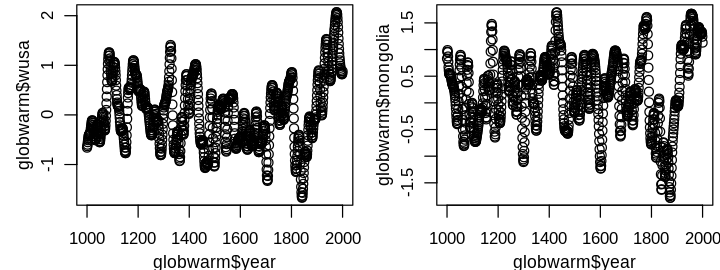

In [5]:

set_pars(panels=2)
plot(globwarm$year, globwarm$wusa)
plot(globwarm$year, globwarm$mongolia)


Note that this does not exclude the use of year in informing the model, e.g. model diagnostics.
A graphical summary of the response nhtemp and predictors is shown next.

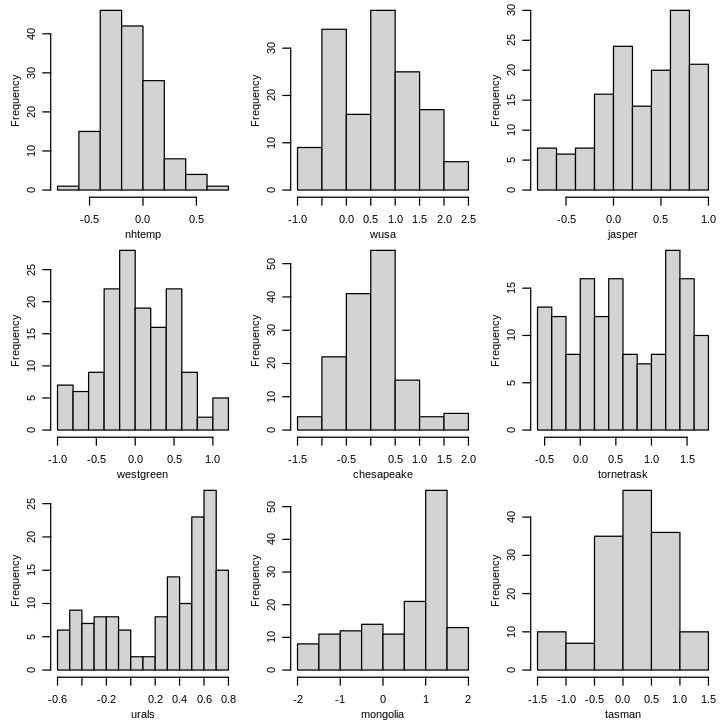

In [6]:

options(repr.plot.width = 6, repr.plot.height = 6)
par(mfrow = c(3, 3), mar = c(2.5, 3, 0, .1) + .2, mgp = c(1.8, .8, 0), ps = 10)
summary_plot(df[, !(names(df) %in% 'year')])


Tree ring proxies `jasper`, `urals`, and `mongolia` are strongly skewed left.
`tornetrask`, another tree ring proxy, appears nearly uniform.
The other variables, including the response, are approximately symmetric and unimodal.
It is also worth considering relationships between variables.
I do this using Spearman's rank correlation, which measures the strength of monotonic (but not necessarily linear) relationships.

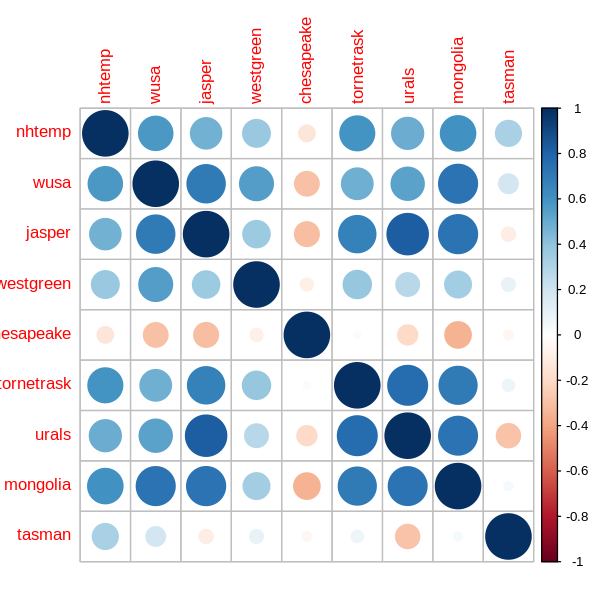

In [7]:

set_pars(dim=c(5, 5))
correlations <- cor(df[, !(names(df) %in% 'year')], method = 'spearman')
corrplot(correlations)


A few variables have multiple strong correlations, e.g. `mongolia` and `urals`, so I may need to address collinearity later although it is less problematic for prediction.
There is little noise in the proxy data from year to year, so scatterplots of proxies exhibit interesting relationships over time even when there is little correlation.

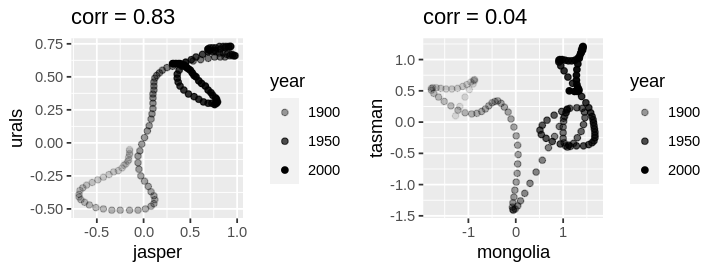

In [8]:

set_pars(panels=2)
plot1 <- ggplot(df) + geom_point(aes(jasper, urals, alpha = year)) +
  ggtitle(paste('corr =', round(correlations['jasper', 'urals'], 2)))
plot2 <- ggplot(df) + geom_point(aes(mongolia, tasman, alpha = year)) +
  ggtitle(paste('corr =', round(correlations['mongolia', 'tasman'], 2)))
grid.arrange(plot1, plot2, ncol = 2)


Scatterplots of response against correlated proxies yield more familiar plots; indeed the response is more variable which is why we're modeling it with a random error.

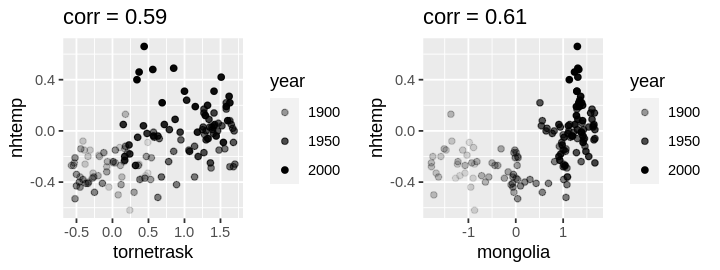

In [9]:

set_pars(panels=2)
plot1 <- ggplot(df) + geom_point(aes(tornetrask, nhtemp, alpha = year)) +
  ggtitle(paste('corr =', round(correlations['tornetrask', 'nhtemp'], 2)))
plot2 <- ggplot(df) + geom_point(aes(mongolia, nhtemp, alpha = year)) +
  ggtitle(paste('corr =', round(correlations['mongolia', 'nhtemp'], 2)))
grid.arrange(plot1, plot2, ncol = 2)


The left (right) plot exhibits a (non)linear trend. Because prediction is of primary interest, I will consider nonlinear transformations later.

## Model diagnostics and (re)selection).
For now, nothing is particularly alarming, so I'll start with a simple model linear in all predictors.
Since we're interested in past prediction, I'll reserve 30% of the oldest data as a test set to select the best model, measured by RMSE, and build the model on the rest of the data.

In [10]:

n <- nrow(df)
test <- df[1:floor(n*.3), ]
train <- df[(floor(n*.3)+1):n, ]
lmod <- lm(nhtemp ~ . - year, train)
sumary(lmod)

             Estimate Std. Error t value Pr(>|t|)
(Intercept) -0.421128   0.139750 -3.0134 0.003328
wusa         0.149016   0.078883  1.8891 0.061997
jasper      -0.302376   0.108297 -2.7921 0.006356
westgreen   -0.034597   0.076258 -0.4537 0.651114
chesapeake  -0.024290   0.054720 -0.4439 0.658152
tornetrask   0.088663   0.053118  1.6692 0.098450
urals        0.493856   0.219341  2.2515 0.026706
mongolia     0.032372   0.070700  0.4579 0.648112
tasman       0.104790   0.054379  1.9270 0.057031

n = 102, p = 9, Residual SE = 0.18948, R-Squared = 0.42



The residual standard error is moderate: $2 \times RSE$ is more than the interquartile range.
I'll examine R's default diagnostic plots next.

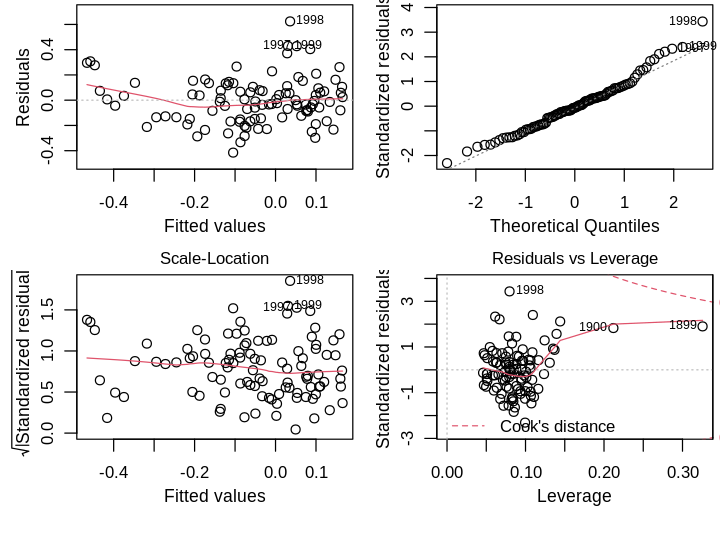

In [11]:

set_pars(panels=4)
plot(lmod)


1. **Residuals vs Fitted.** There is no obvious trend suggestive of poor model structure. There are a few large residuals, particularly the later years implying the model underestimates the latest data.
2. **Normal Q-Q.** The right tail violates the normality assumption, which seem to be the latest data.
3. **Scale-Location.** The residuals do not deviate much from the constant variance assumption.
4. **Residuals vs Leverage.** The oldest points in the dataset, 1899 and 1900, have the highest leverage and influence, but not high enough for me to consider their removal.
Aside from normality of errors, which is the least important assumption, the simple model looks OK.
One could argue the large residuals are problematic for past predictions; perhaps they are indicative of global warming in recent years, a small range of time with distinct behavior that my simple linear model cannot capture.
I’ll test this formally using leave-one-out Studentized residuals, which are approximately distributed as $\mathcal{T}(n−p−1)$, where $p$ is the number of parameters.
Using a Bonferroni correction at the $\alpha=0.05$ level,

In [12]:

tresid <- rstudent(lmod)
which(abs(tresid) > abs(qt(.05/n, lmod$df.residual - 1)))

1998 
 100


only the largest residual is a statistical outlier.
Before I consider removing it, I’ll investigate a larger issue that is difficult to observe from the above four diagnostics: the independent errors assumption.
This assumption can be difficult to check in general, and often requires some domain knowledge.
Time series data is often correlated because variables don’t change instantaneously.
For instance, today’s temperature is correlated with tomorrow’s; dramatic swings in daily temperature are rare.
Unless the model perfectly predicts these seasonal correlations, I’d expect residuals to be correlated from year to year.
This is hard to see from the diagnostic plots because year has not yet informed our model, but can be seen in plots of residuals against year and $\widehat{\varepsilon}_{i+1}$ against $\widehat{\varepsilon}_i$.

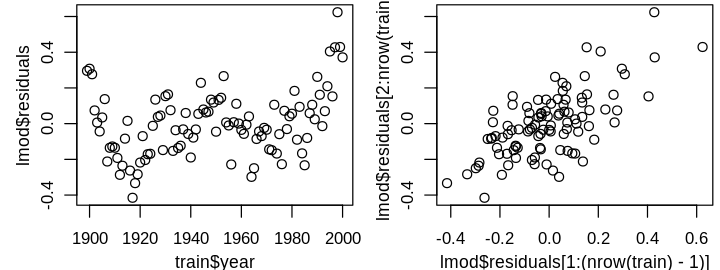

In [13]:

set_pars(panels=2)
plot(train$year, lmod$residuals)
plot(lmod$residuals[1:(nrow(train)-1)], lmod$residuals[2:nrow(train)])


To address the correlated errors, I’ll use generalized least squares (GLS) with an AR1 correlation structure.
Specifically, I’ll model the the errors as a linear 1-step lag:

$$ \varepsilon_{i+1} = \phi \varepsilon_i + \delta_i $$

where $\delta_i \sim \mathcal{N}(0, \tau^2)$. The resultant covariance matrix of the errors has the form

$$
  \boldsymbol{\Sigma} = \sigma^2 \Matrix{
    1 & \phi & \phi^2 & \cdots & \phi^n \\
      & 1    & \phi   & \cdots & \phi^{n-1} \\
      &      & 1   & \cdots & \phi^{n-2} \\
      &      &     & \ddots & \vdots \\
      &      &     &  & 1 \\
  }
$$

We can then transform the response and design matrix to $\boldsymbol{y}'=\boldsymbol{S}^{-1} \boldsymbol{y}$ and  and $\boldsymbol{X}'=\boldsymbol{S}^{-2}\boldsymbol{X}$, where $\boldsymbol{S}$ is obtained from the Choleski decomposition $\boldsymbol{\Sigma}=\boldsymbol{S}\boldsymbol{S}^{T}$, and regress $\boldsymbol{y}'$ on $\boldsymbol{X}'$:

$$ \boldsymbol{y}' = \boldsymbol{X}'\boldsymbol{\beta} + \boldsymbol{\varepsilon}' $$

```{margin}
$^{\dagger}$ There appear to be two estimated parameters in the AR1 covariance matrix: $\sigma$ and $\phi$. However, we don’t actually need to specify $\sigma$ for GLS to work. We only need to specify a covariance matrix proportional to $\boldsymbol{\Sigma}$; the constant  $\sigma^2$ just amounts to a change in scale which is irrelevant in the transformed regression model.
```
If $\boldsymbol{\Sigma}$ is correctly specified, the transformed errors $\boldsymbol{\varepsilon}'=\boldsymbol{S}^{-1} \boldsymbol{\varepsilon}$ are i.i.d.$^{\dagger}$
I’ll implement GLS using the nlme package.

In [14]:

library(nlme)
glmod <- gls(nhtemp ~ . - year, correlation = corAR1(form = ~ year), train)
summary(glmod$modelStruct)

Correlation Structure: AR(1)
 Formula: ~year 
 Parameter estimate(s):
     Phi 
0.856977 



We observe strong correlation between residuals. Let’s see how the coefficients change:

In [15]:

summary(glmod)$tTable

,Value,Std.Error,t-value,p-value
(Intercept),-0.18738021,0.3107210,-0.60304977,0.5479434
wusa,0.00769262,0.1829881,0.04203891,0.9665578
jasper,-0.17928669,0.3205254,-0.55935245,0.5772658
westgreen,0.06251127,0.1632877,0.38282892,0.7027202
chesapeake,0.05893335,0.1242621,0.47426633,0.6364217
tornetrask,0.01636588,0.1311168,0.12481914,0.9009361
urals,0.36419117,0.5579029,0.65278590,0.5155048
mongolia,0.02987473,0.2015126,0.14825242,0.8824645
tasman,0.10277331,0.1545286,0.66507626,0.5076477



Point estimates change and there is substantially more uncertainty.
Remember, though, from a statistical standpoint this model should be better, e.g. its residuals should no longer be correlated.
`gls` objects do not have the four graphical diagnostics we are accustomed to.
I’ll implement GLS using `lm()` instead, with the help of other functions from `nlme` to specify the covariance structure $\boldsymbol{\Sigma}$  and transform the data accordingly, using the estimated $\phi$ above.

In [16]:

Sigma <- corMatrix(glmod$modelStruct$corStruct)
S <- t(chol(Sigma))
y <- solve(S) %*% train$nhtemp  # y'
X <- solve(S) %*% model.matrix(nhtemp ~ . - year, train)  # X'
rownames(y) <- rownames(X) <- rownames(train)
glmod <- lm(y ~ X + 0)
sumary(glmod)

               Estimate Std. Error t value Pr(>|t|)
X(Intercept) -0.1873802  0.3107210 -0.6030   0.5479
Xwusa         0.0076926  0.1829881  0.0420   0.9666
Xjasper      -0.1792867  0.3205254 -0.5594   0.5773
Xwestgreen    0.0625113  0.1632877  0.3828   0.7027
Xchesapeake   0.0589333  0.1242621  0.4743   0.6364
Xtornetrask   0.0163659  0.1311168  0.1248   0.9009
Xurals        0.3641912  0.5579029  0.6528   0.5155
Xmongolia     0.0298747  0.2015126  0.1483   0.8825
Xtasman       0.1027733  0.1545286  0.6651   0.5076

n = 102, p = 9, Residual SE = 0.27744, R-Squared = 0.03



We’ve recovered the same GLS model using `lm()`. On to diagnostics, which appear substantially different:

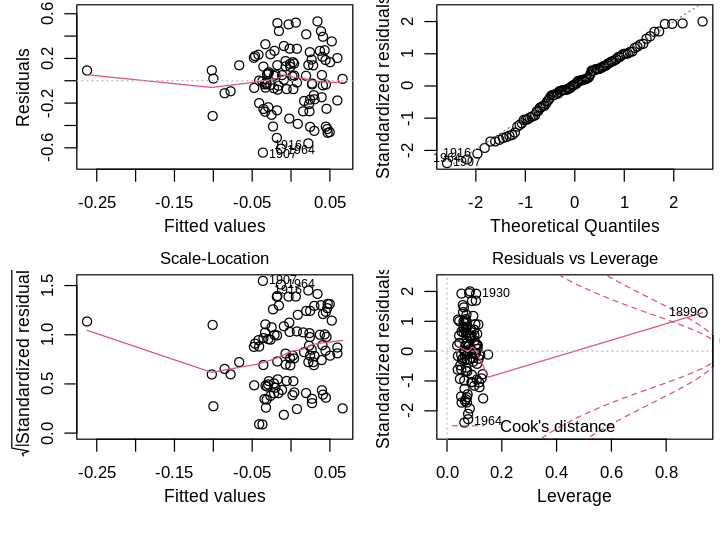

In [17]:

set_pars(panels=4)
plot(glmod)

```{margin}
$^{\dagger}$ Removal leads to a model with substantial changes to estimates and errors. Prediction on the test set is substantially worse.
```
1988 is no longer an outlier&mdash;in fact, no Studentized residual is statistically significant after Bonferroni correction at $\alpha=0.05$.
1899 is now a high leverage point point with large influence.
However, this is an artifact of the transformed design matrix $\boldsymbol{X}$', whose first row is identical to $\boldsymbol{X}$. For this reason, I won’t remove this point.$^{\dagger}$ The qqplot is improved, though still has a problematic right tail. The GLS model introduces heteroscedasticity, which I’ll address later. Importantly, residual plots no longer show correlation.

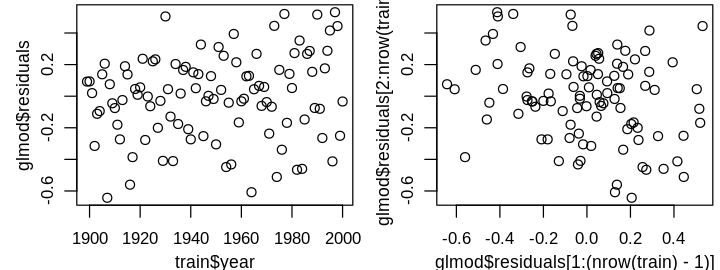

In [18]:

set_pars(panels=2)
plot(train$year, glmod$residuals)
plot(glmod$residuals[1:(nrow(train)-1)], glmod$residuals[2:nrow(train)])


To check the degree of collinearity, I examined the condition numbers. The largest was 11.75677, so I won’t take any special precautions.
We can’t address heteroscedasticity using a Box–Cox transformation of the response because some $y<0$. Residuals plots against each predictor don’t suggest any predictor transformations. Instead, I’ll add another candidate model using weights. Since year and nhtemp are correlated and higher predicted nhtemp values have more variance, I’ll use some form of temporal weighting.

Warning message in sqrt(crit * p * (1 - hh)/hh):
“NaNs produced”


Warning message in sqrt(crit * p * (1 - hh)/hh):
“NaNs produced”


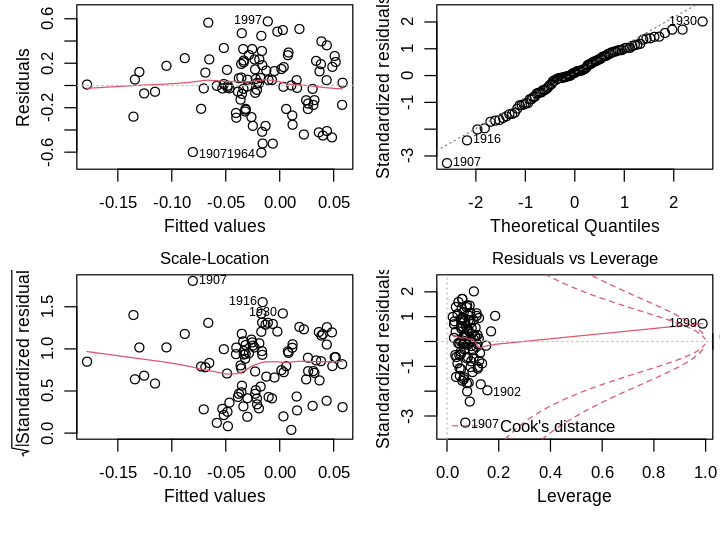

In [19]:

set_pars(panels=4)
wts <- 1/(as.integer(rownames(X)) - min(as.integer(rownames(X))) + 1)**.5
wglmod <- lm(y ~ X + 0, weights = wts)
plot(wglmod)


The exact form of the weights was found by trial and error. The resultant weights span a large range; the oldest point is weighed more than 10 times the most recent point, which results in a larger Cook’s distance. I’ll see whether the weights help in prediction next, skipping variable selection since $n/p$ is not too small and we’re focused on prediction.

## Optimizing predictive accuracy

I’ll grade models on the mean RMSE of their predictions for the test data.

In [20]:

get_rmse <- function(ypred, yobs) {
  sqrt(mean((ypred - yobs)**2))
}


Since the GLS models were trained on transformed data, I’ll compute predictions using extracted model coefficients rather than the `predict()` method.

In [21]:

X_test <- model.matrix(nhtemp ~ . - year, test)
get_rmse(X_test %*% coef(lmod), test$nhtemp)

[1] 0.3044834

In [22]:

get_rmse(X_test %*% coef(glmod), test$nhtemp)

[1] 0.1648465

In [23]:

get_rmse(X_test %*% coef(wglmod), test$nhtemp)

[1] 0.2260385


The AR1 model without the additional weighting performs best. There is the possibility of improvement if we use shrinkage methods. I’ll employ ridge regression using the glmnet package, which allows us to flexibly shrink predictor coefficients; in particular, we can specify no penalty on the (transformed) intercept term in the GLS models.

In [24]:

install.packages('glmnet')
library(glmnet)

Warning message in install.packages("glmnet"):
“installation of package ‘glmnet’ had non-zero exit status”


Updating HTML index of packages in '.Library'



Making 'packages.html' ...


 done



Loading required package: Matrix



Loaded glmnet 4.1-2



In [ ]:
set.seed(1)  # For reproducibility (from cross-validation).
ridge_lmod <- cv.glmnet(
  x = as.matrix(train[, !(names(train) %in% c('nhtemp', 'year'))]),
  y = train$nhtemp, alpha = 0, intercept = TRUE
)
get_rmse(X_test %*% coef(ridge_lmod), test$nhtemp)

In [ ]:

ridge_glmod <- cv.glmnet(
  X, y, alpha = 0, intercept = FALSE, penalty.factor = c(0, rep(1, ncol(X)-1))
)
get_rmse(X_test %*% coef(ridge_glmod)[2:(ncol(X)+1)], test$nhtemp)

In [ ]:

ridge_wglmod <- cv.glmnet(
  X, y, alpha = 0, intercept = FALSE, penalty.factor = c(0, rep(1, ncol(X)-1)),
  weights = wts
)
get_rmse(X_test %*% coef(ridge_wglmod)[2:(ncol(X)+1)], test$nhtemp)


Surprisingly, the linear model with ridge regression obtains the best accuracy among all models considered. Ridge regression doesn’t benefit the GLS models—inspection of the penalized coefficients show all terms but the intercept are shrunk to zero. I’ll continue with `glmod` and `ridge_lmod` to compare their predictions. If there are stark differences I’ll need to think harder on picking one model.

## Making predictions

I’ll train the models on all data with available `nhtemp`.

In [ ]:

ridge_lmod <- cv.glmnet(
  x = as.matrix(df[, !(names(df) %in% c('nhtemp', 'year'))]),
  y = df$nhtemp, alpha = 0, intercept = TRUE
)

glmod <- gls(nhtemp ~ . - year, correlation = corAR1(form = ~ year), df)


Prediction on all data are computed next.

In [ ]:

ridge_lmod_pred <- predict(
  ridge_lmod,
  newx = as.matrix(globwarm[, !(names(globwarm) %in% c('nhtemp', 'year'))])
)
glmod_pred <- predict(glmod, globwarm[, !(names(globwarm) %in% c('nhtemp'))])


I think it’s instructive to first plot the fits on the subset of fully available data.

In [ ]:

set_pars(panels=1)
plot(df$year, df$nhtemp)
lines(globwarm$year, ridge_lmod_pred, col = 2)
lines(globwarm$year, glmod_pred, col = 3, lty = 1)
legend('topleft', legend = c('ridge', 'GLS'), lty = 1, col = 2:3)


The GLS model better captures temporal variation, while the ridge model hovers around the mean temperature -0.12034. This feature is even more pronounced when we predict back to year 1000, leading to drastically different predictions.

In [ ]:

set_pars(dim=c(8, 3))
plot(globwarm$year, globwarm$nhtemp)
lines(globwarm$year, ridge_lmod_pred, col = 2)
lines(globwarm$year, glmod_pred, col = 3)
legend('topleft', legend = c('ridge', 'GLS'), lty = 1, col = 2:3)


Since the ridge model makes no correction for the strongly correlated residuals, other than shrinking estimates, I favor the GLS model.